In [5]:
from pandas_datareader import data as pdr
import pandas as pd
import numpy as np
import cvxpy as cvx
from scipy.stats import norm
from numpy.linalg import inv
import math

import keras
import seaborn as sns
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

# for plotting
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import matplotlib.pyplot as plt

# Initialize plotly offline
plotly.offline.init_notebook_mode(connected=True)

In [6]:
import warnings
warnings.filterwarnings('ignore')

### Data functions

In [7]:
# Download Stock data from Yahoo Finance
def download_stock_data(start_date, end_date, asset_list, filename):
    """
    asset_list: list of asset to download
    filename: name of the csv file where the data go to
    """
    for i, asset in enumerate(asset_list):
        if i == 0:
            data = pdr.get_data_yahoo(asset_list[i], start_date,end_date)[['Adj Close']]
            all_prices = data.rename(columns={"Adj Close": asset})
            
        else:
            new_asset = pdr.get_data_yahoo(asset_list[i], start_date,end_date)[['Adj Close']]
            all_prices = all_prices.join(new_asset.rename(columns={"Adj Close": asset}))
    
    all_prices.to_csv('./00_Data/' + filename + '.csv')
    return

# Extract Return and accumulated price data (starting value 1) from raw stock prices
def process_stock_data(all_prices):
    """
    input:
    all_prices: data frame, price of a list of stock from start date to the end date
    
    return:
    all_price_norm: normalized asset price with the price on the first day as 1
    all_returns: relative price
    """
    n_time, n_assets = all_prices.shape
    # Calculate returns
    all_returns = all_prices.pct_change(1).apply(lambda a : a + 1)
    
    # Calculate relative price time series
    all_prices_norm = all_returns.copy()
    for i in range(n_time):
        if i == 0:
            all_prices_norm.iloc[0] = np.ones(n_assets)
        else:
            for j in range(n_assets):
                if math.isnan(all_prices_norm.iloc[i,j]):
                    all_prices_norm.iloc[i,j] = all_prices_norm.iloc[i-1,j]
                else:
                    all_prices_norm.iloc[i,j] = all_prices_norm.iloc[i,j] * all_prices_norm.iloc[i-1,j]
                    
    return all_prices_norm, all_returns.dropna()

#1/fluc, 1, 1/fluc, 1, ...
def teststock1(T, fluc):
    stock = np.ones(T+1)
    for i in range(T+1):
        if i%2 == 1:
            stock[i] = 1.0/fluc
    return stock

#Brownian Motion
def teststock2(T, delta, sigma):
    stock1 = np.zeros(T+1)
    stock1[0] = 3.0
    for i in range(T):
        stock1[i+1] = stock1[i] + sigma + norm.rvs(scale=delta**2)
        if (stock1[i+1] <= 0):
            print('Negative Warning!')
    return stock1

#Garbage 1, 1/fluc, 1/pow(fluc,2) ,...
def teststock3(T, discount):
    stock = np.ones(T+1, dtype=float)
    for i in range(T):
        stock[i+1] = stock[i]*discount
    return stock

In [8]:
# download stock data and safe as csv in /Data folder
commodities = ['GC=F','SI=F', 'CL=F'] #gold, silver, Crude Oil
bonds = ['^FVX'] #5 Year US Government Bonds
us_stocks = ['SPY', # The SP500 as a benchmark
             'AAPL', 'MMM', 'BA' , 'CAT', 'CVX' , 'CSCO', 'KO' , 'DIS',
             'GS', 'IBM', 'INTC', 'JNJ', 'JPM', 'MSFT', 'PFE'] #Some stocks from the Dow Jones

start_data = '2008-09-01'
end_date = '2008-10-01'

#Download and save data as csv
#download_stock_data(start_data, end_date, commodities, 'Commodities_latest')
#download_stock_data(start_data, end_date, bonds, 'bonds_latest')
download_stock_data(start_data, end_date, us_stocks, 'us_stocks_latest')

ConnectionError: HTTPSConnectionPool(host='finance.yahoo.com', port=443): Max retries exceeded with url: /quote/SPY/history?period1=1220212800&period2=1222891199&interval=1d&frequency=1d&filter=history (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x141dc1160>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [11]:
# read in the data again
us_stock_prices = pd.read_csv('./00_Data/us_stocks_latest.csv', header=0, index_col = 0)
us_stock_prices.index = pd.to_datetime(us_stock_prices.index)

#Process Stock Data
stock_prices_norm, stock_returns = process_stock_data(us_stock_prices)

# Extract benchmark SP500 Data
SPY_benchmark = stock_prices_norm.drop(us_stocks[1:], axis=1)
stock_prices_norm_wo_SPY = stock_prices_norm.drop(us_stocks[0], axis=1)

# filter out benchmark data from stock returns
stock_returns = stock_returns.drop(us_stocks[0], axis=1)

In [13]:
# Plot prices
iplot(us_stock_prices.iplot(asFigure=True, kind='scatter',xTitle='Dates',yTitle='Prices',title='Prices'))

# Plot returns
iplot(stock_returns.iplot(asFigure=True, kind='scatter',xTitle='Dates',yTitle='Returns',title='Returns'))

# Plot normalized prices
iplot(stock_prices_norm.iplot(asFigure=True, kind='scatter',xTitle='Dates',yTitle='Relative Price',title='Relative Prices'))

#### 2. Risk-aware portfolio

We are going to use the Python package "cvxpy" to do the optimization, since to find the risk-aware portfolio, we are basically solving a convex optimization problem.

cvxpy tutorial: [here](https://colab.research.google.com/github/cvxgrp/cvx_short_course/blob/master/applications/portfolio_optimization.ipynb#scrollTo=cIA0uezJ91Xl)

Recall that the convex optimization problem is

\begin{equation}
\omega_t^C = \underset{(\mathbf{u},\alpha)\in (\Delta, \mathbb{R})}{\operatorname{argmin}}\left\{\alpha+\frac{1}{(\delta + t - 1)(1-\gamma)}\left[\sum_{s=1}^{\delta}(-u^TH_s-\alpha)^++\sum_{s=1}^{t-1}(-u^TR_s-\alpha)^+\right]\right\}
\end{equation}

Functions that might be useful:
- cvxpy.pos(x)
- cvxpy.sum(X)
- stock_returns.dot(u), combined with .iloc[]
- .values, transfer dataframe into array (or np.ravel() works as well)

To run a convex optimization problem, we need to specify:
- The variable we are to optimize: cp.Variable()
- The parameters in the model: cp.Parameter()
- The objective function we are to maximize or minimize: obj
- Constraints: for example, w = cp.Variable(5) and the constraint is cp.sum(w) == 1. The constraint can be a list.
- Form the optimization problem: for example, prob = cp.Problem(cp.Maximize(obj), constraints)
- Finally, we call .solve() to solve the constrained optimization problem: prob.solve()
- We can extract the value of variables by calling u.value

In [81]:
type(stock_returns.iloc[:1])

pandas.core.frame.DataFrame

In [47]:
def Risk_Aware_Portfolio(stock_returns, gamma, delta):
    """
    input:
    stock_return: returns for the stock data
    gamma: the confidence level
    delta: number of dates we use to estimate the density of returns
    
    output:
    portfolio: portfolio selected
    """
    u = cp.Variable((stock_returns.shape[1], 1))
    a = cp.Variable()
    #     gamma = cp.Parameter(gamma)

    constraints = [cp.sum(u) == 1, u >= 0]

    portfolio = []

    for t in range(2, len(stock_returns)):
        coefficient = 1 / ((delta + t - 1) * (1 - gamma))

        sliced = stock_returns.iloc[:delta]
        sliced = sliced.to_numpy()
        inner_part = cp.pos(sliced * (-u) - a)
        first_sum = cp.sum(inner_part)

        sliced2 = stock_returns.iloc[:t - 1]
        sliced2 = sliced2.to_numpy()
        inner_part2 = sliced2 * (-u) - a
        second_sum = cp.sum(cp.pos(inner_part2))

        obj = cp.Minimize(a + coefficient * (first_sum + second_sum))

        prob = cp.Problem(obj, constraints)
        prob.solve(solver='SCS')
        portfolio.append(u.value)

    return portfolio

    """
    n_time, n_assets = stock_returns.shape
    portfolio = np.zeros((n_assets, n_time)) # the output portfolio
    u = cp.Variable(n_assets) # portfolio vector
    alpha = cp.Variable() # auxiliary variable
    
    constraints = [cp.sum(u) == 1, 
                u >= 0]
    Gamma = cp.Parameter(nonneg = True,value = gamma)
    
    for t in range(delta + 1, n_time):
        R = stock_returns.iloc[:t,:].dot(u).values
        fct =  alpha + (cp.pos(-cp.sum(R[:delta])-alpha)+cp.pos(-cp.sum(R[:t-1])-alpha))/((delta + t - 1)*(1 - Gamma))
        prob = cp.Problem(cp.Minimize(fct), constraints)
        p = prob.solve()
        portfolio[:,t] = u.value
        
    return portfolio
    """

In [48]:
result = Risk_Aware_Portfolio(np.log(stock_returns), 0.95, 30)

In [62]:
np.sum(result, axis = 1)

array([[1.00000086],
       [1.00000277],
       [0.99999841],
       [0.99999856],
       [1.0000006 ],
       [0.99999646],
       [1.00000504],
       [0.99999447],
       [0.99999659],
       [1.00000009],
       [1.00000807],
       [1.00000088],
       [0.99999944],
       [0.99998997],
       [1.00000037],
       [0.99999443],
       [0.99999559],
       [1.00000423],
       [1.0000061 ],
       [1.00000351],
       [1.00000023],
       [0.99999661],
       [0.99999563],
       [1.00000441],
       [1.00000038],
       [0.99998808],
       [0.99999846],
       [0.99999849],
       [0.99999207],
       [1.00000145],
       [1.00000356],
       [1.00000522],
       [0.99999425],
       [0.99999734],
       [0.99999661],
       [0.99999918],
       [0.99998963],
       [1.00000007],
       [0.99998762],
       [1.00000002],
       [1.00000636],
       [1.00000955],
       [1.00000434],
       [0.99999651],
       [1.0000075 ],
       [0.99999595],
       [0.99999911],
       [1.000

### Method 2: Deep portfolio using neural network

Next we are to implement the deep portfolio. Recall the four step procedure: 
- **Auto-encoding**: this phase is essentially dimension reduction. *In the paper: one hidden layer with five neurons*.
- **Calibration**: using the stock price of the first few years, our target index $Y$ is the S&P500 (we can also play with this target so that the portfolio map can possibly outperform S&P500 -- but this is for later). *In the paper: ReLU and 4-fold cross validation*. 
- **Validation**: out-sample validation. Will need to test with different number of stocks.
- **Verification**: deep frontier. We look at the 2-norm out-of-sample error for different number of stocks used.

We are to use the "keras" package.

In [8]:
"""
import sys
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install tensorflow

import keras
import seaborn as sns
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
"""

'\nimport sys\n!{sys.executable} -m pip install keras\n!{sys.executable} -m pip install seaborn\n!{sys.executable} -m pip install sklearn\n!{sys.executable} -m pip install tensorflow\n\nimport keras\nimport seaborn as sns\nimport sklearn\nimport tensorflow as tf\nimport matplotlib.pyplot as plt\nfrom sklearn.model_selection import StratifiedKFold\n'

<module 'seaborn' from '/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/__init__.py'>

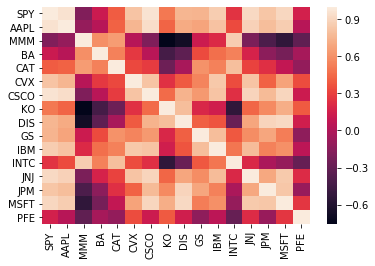

In [9]:
corr = us_stock_prices.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
sns

Here is the [keras cheat sheet](https://datacamp-community-prod.s3.amazonaws.com/94fc681d-5422-40cb-a129-2218e9522f17).

And [here](https://www.datacamp.com/community/tutorials/deep-learning-python?utm_source=adwords_ppc&utm_campaignid=1565261270&utm_adgroupid=67750485268&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=1t2&utm_creative=295208661502&utm_targetid=aud-299261629574:dsa-473406573755&utm_loc_interest_ms=&utm_loc_physical_ms=9032083&gclid=Cj0KCQjwjrvpBRC0ARIsAFrFuV8n3NeR3fjxjmePLhLuI3Wa1trhj4-amYGDMgORxi50h5f4LMe7iqEaAlYeEALw_wcB) is a tutorial of deep learning in python using keras, with examples.

But in short, this is how you build a one-layer neural network. Let's look at the auto-encoder.

The auto-encoder is going to be a one-layer fully connected network, with, let's say, 5 neurons in the hidden layer. We start with building the network structure. You will need to specify:
- The connection structure: we call "keras.layers.Dense()", to denote a fully connected neural network.
- Initilization: model = Sequential()
- Add layers: model.add()
- Activation functions: 'relu' ('softmax', 'tanh'...)
- inpit_dim: only need to specify this in the input layer
- units: dimension of the output

We can also add regularizer: for example, model.add(Dense(...,kernel_regularizer = regularizers.l2(0.01),...))

## Autoencoder

In [10]:
# read in the data again
stock_prices = pd.read_csv('./00_Data/hundred_stocks.csv', header=0, index_col = 0)
stock_prices.index = pd.to_datetime(stock_prices.index)

#Process Stock Data
stock_prices_norm, stock_returns = process_stock_data(stock_prices)

In [11]:
subprime_mortgage_crisis = stock_prices.loc['2008-09'].dropna(axis=1) 
SMPC_returns = process_stock_data(subprime_mortgage_crisis)[1] # H_i,t of each asset i for t = 1,...,20

In [1]:
# Import `Sequential` from `keras.models`
from keras.models import Sequential
from keras.optimizers import RMSprop
opt = RMSprop(lr=0.001)

# Import `Dense` from `keras.layers`
from keras.layers import Dense

# Initialize the constructor
model = Sequential()

#input 87 stock data, and the hidden layer has 5 neurons; no biased involved (unless we let use_bias = TRUE)
model.add(Dense(units = 3, input_dim = 87, activation='relu', kernel_initializer = 'he_normal', use_bias = False))
model.add(Dense(units = 87, activation='relu', use_bias = False))

Using TensorFlow backend.
W0731 17:02:21.721014 4656436672 deprecation_wrapper.py:119] From /usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0731 17:02:21.722759 4656436672 deprecation_wrapper.py:119] From /usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 17:02:21.731525 4656436672 deprecation_wrapper.py:119] From /usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0731 17:02:21.740429 4656436672 deprecation_wrapper.py:119] From /usr/local/Ce

After building the network structure, we compile the network model by calling .compile(). We also need to specify:
- The optimizer: specific method we are to use when training the weights and bias. Some common optimizers: adam, rmsprop, sgd
- loss function: mse, cross-entropy
- metrics: to indicate the goodness of training

In [117]:
model.compile(optimizer=opt, loss='mse', metrics=['mae'])

Finally we train the network. We specify:
- epochs: number of time we go over the training data
- batch
- verbose: show the training progress bar or not

In [118]:
# one_d = [j for sub in SMPC_returns.values.tolist() for j in sub]

In [216]:
model.fit(SMPC_returns, SMPC_returns, epochs = 500, verbose = 1)

ValueError: Error when checking target: expected dense_20 to have shape (87,) but got array with shape (1,)

In [79]:
y_hat = list(model.predict(one_d))
y_hat = [x[0] for x in y_hat] # for some reason each element is wrapped in an array. Turning them back into doubles.

In [80]:
# group each 20 numbers to reconstruct 2d array
returns = []
current_stock_returns = []
for i in range(len(y_hat)):
    if (i+1) % 20 == 0 and not (i == 0):
        returns.append(current_stock_returns)
        current_stock_returns = []
    current_stock_returns.append(y_hat[i])

## Predict SPY Code

In [4]:
result = pd.DataFrame(model.predict(SMPC_returns))

# Error
norm2 = np.linalg.norm(result.values - SMPC_returns.values, axis = 0)
sorted_ = np.sort(norm2).tolist()
sorted_ = [sorted_.index(x) for x in norm2.tolist()] # Wrong logic. fixed in new notebook
picked = sorted_[:5] + sorted_[-5:]

NameError: name 'pd' is not defined

In [2]:
def normalized(returns):
    returns_temp = returns - np.mean(returns)
    variance = np.sum(returns ** 2)/len(returns)
    returns_temp /= variance
    return returns_temp

In [293]:
normalized_SPY = normalized(SPY_benchmark)

In [155]:
input_stocks = SMPC_returns.iloc[:,picked]

In [247]:
model = Sequential()

#input 87 stock data, and the hidden layer has 5 neurons; no biased involved (unless we let use_bias = TRUE)
model.add(Dense(units = 3, input_dim = 10, activation='relu', kernel_initializer = 'he_normal', use_bias = False))
model.add(Dense(units = 1, activation='relu', use_bias = False))

In [269]:
opt = RMSprop(lr=0.0001)

In [248]:
model.compile(optimizer=opt, loss='mse', metrics=['mae'])

In [295]:
model.fit(input_stocks, normalized_SPY, epochs = 200, verbose = 1)

Epoch 1/200
20/20 [==============================] - 0s 86us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 2/200
20/20 [==============================] - 0s 96us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 3/200
20/20 [==============================] - 0s 103us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 4/200
20/20 [==============================] - 0s 121us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 5/200
20/20 [==============================] - 0s 100us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 6/200
20/20 [==============================] - 0s 168us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 7/200
20/20 [==============================] - 0s 124us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 8/200
20/20 [==============================] - 0s 95us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 9/200
20/20 [==============================] - 0s 82us/step - loss: 0.0011 - mean_absolute_error: 0.0

Epoch 74/200
20/20 [==============================] - 0s 90us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 75/200
20/20 [==============================] - 0s 147us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 76/200
20/20 [==============================] - 0s 95us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 77/200
20/20 [==============================] - 0s 86us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 78/200
20/20 [==============================] - 0s 72us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 79/200
20/20 [==============================] - 0s 76us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 80/200
20/20 [==============================] - 0s 71us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 81/200
20/20 [==============================] - 0s 67us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 82/200
20/20 [==============================] - 0s 84us/step - loss: 0.0011 - mean_absolute_error

Epoch 147/200
20/20 [==============================] - 0s 116us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 148/200
20/20 [==============================] - 0s 93us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 149/200
20/20 [==============================] - 0s 116us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 150/200
20/20 [==============================] - 0s 103us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 151/200
20/20 [==============================] - 0s 83us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 152/200
20/20 [==============================] - 0s 88us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 153/200
20/20 [==============================] - 0s 106us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 154/200
20/20 [==============================] - 0s 92us/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 155/200
20/20 [==============================] - 0s 66us/step - loss: 0.0011 - mean_ab

In [299]:
normalized_SPY

,SPY
Date,
2008-09-03,0.051382
2008-09-04,0.018257
2008-09-05,0.021613
2008-09-08,0.043724
2008-09-09,0.011288
2008-09-10,0.015590
2008-09-11,0.030991
2008-09-12,0.035981
2008-09-15,-0.015642


In [297]:
model.predict(input_stocks)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

When doing the calibration, we do k-fold cross validation to do model selection. We call the StratifiedKFold from sklearn.model_selection.

In [28]:
# from sklearn.model_selection import StratifiedKFold

seed = 7
np.random.seed(seed)

kfold = StratifiedKFold(n_splits = 4, shuffle = True, random_state = seed)
for train, test in kfold.split(X, Y):
    model = Sequential()
    model.add(Dense(units = 5, input_dim = 87, activation='relu'))
    model.add(Dense(units = 1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.fit(X[train], Y[train], epochs = 10, verbose = 1)
    mse_value, mae_value = model.evaluate(X[test], Y[test], verbose = 0)

NameError: name 'StratifiedKFold' is not defined